In [11]:
!pip install --break-system-packages kagglehub matplotlib scikit-learn numpy shap seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.7 MB/s eta 0:00:002.9 MB/s eta 0:00:01


Linear Regression
===

In [4]:
import pandas as pd

In [5]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "insurance.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "mirichoi0218/insurance",
  file_path,
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)


/tmp/ipykernel_31161/3859591330.py:10: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54.3k/54.3k [00:00<00:00, 721kB/s]


Data exploration
===
First, we need to know our data to see which kind of variables we are dealing with.

In [6]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


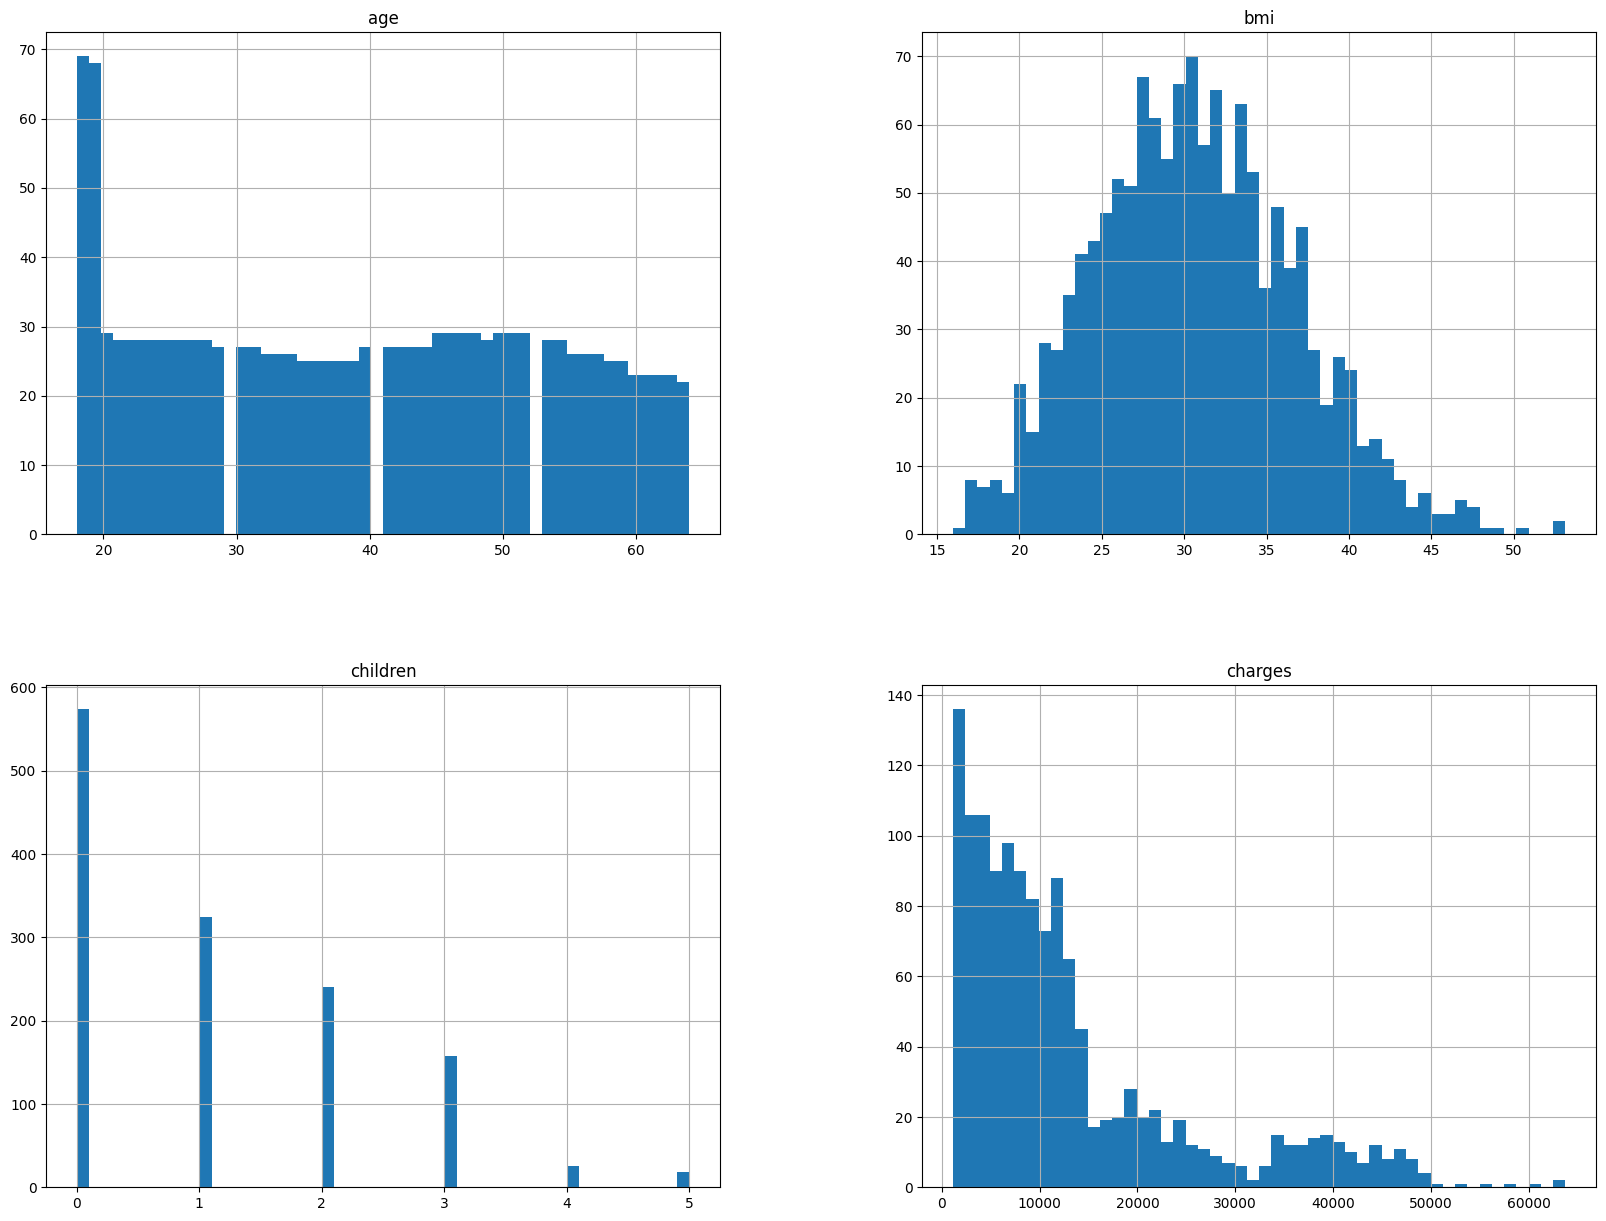

In [7]:
#we plot the numerical columns
import matplotlib.pyplot as plt
df.hist(bins=50, figsize=(20, 15))
plt.show()


Algunos plot de relaciones entre variables para ver distribuciones

Preprocessing
==
-During the initial exploration of the dataset, we observed that some variables are categorical. Since linear regression cannot be directly applied to categorical variables, we convert them using the get_dummies function from pandas, which performs one-hot encoding.

-We want to use our model to predict the insurance charges. Since these charges depend on various factors, we define all other features (such as age, BMI, number of children, etc.)  as our independent variables (X), and the target variable (y) is the charges column.

-We divide our dataset into a training set and a test set to evaluate model performance on unseen data.

-Although normalization is not strictly required for canonical linear regression, it becomes important when using gradient descent. Since some variables like age or children are strictly positive and not centered around zero, we apply normalization to scale the features to the [0, 1] range, which improves convergence during training.

In [8]:
df_encoded = pd.get_dummies(df, drop_first=True,dtype=int) #by setting dtype=int we ensure that the columns are 0 and 1 and not true and false
df_encoded.head()


,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,0,1,0,0,1
1,18,33.770,1,1725.55230,1,0,0,1,0
2,28,33.000,3,4449.46200,1,0,0,1,0
3,33,22.705,0,21984.47061,1,0,1,0,0
4,32,28.880,0,3866.85520,1,0,1,0,0


In [9]:
#we split the data into train and test sets
from sklearn.model_selection import train_test_split
X = df_encoded.drop("charges", axis=1)
y = df_encoded["charges"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear regresion from scratch
=========
To solve linear regression analytically, we use the closed-form equation:

    theta = (X.T * X)^(-1) * X.T * y

This equation assumes that our model includes an intercept (bias) term. To include it, we manually add a column of ones to the input matrix X_scaled. This column represents the intercept in the model.



Mean Absolute Percentage Error (MAPE): 46.89%
R^2 Score: 0.7835929767120724
Coefficients:
age                   256.975706
bmi                   337.092552
children              425.278784
sex_male              -18.591692
smoker_yes          23651.128856
region_northwest     -370.677326
region_southeast     -657.864297
region_southwest     -809.799354
dtype: float64


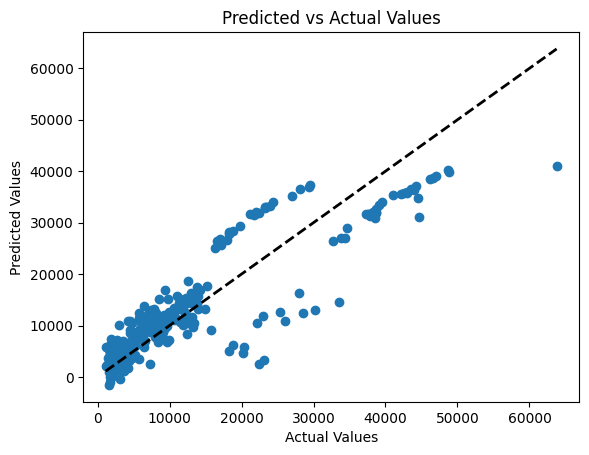

In [10]:
#Version from scratch
import numpy as np

X_b = np.c_[np.ones((X_train.shape[0], 1)), X_train]  # we add the column of ones to X for the bias term
theta= np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y_train

#we can now make predictions
X_test_b = np.c_[np.ones((X_test.shape[0], 1)), X_test]  # we add the column of ones to X for the bias term
y_pred = X_test_b @ theta
#we can now calculate the mape 
from sklearn.metrics import mean_absolute_percentage_error
mape_from_scratch= mean_absolute_percentage_error(y_test, y_pred)
print(f"Mean Absolute Percentage Error (MAPE): {mape_from_scratch * 100:.2f}%")
#we can also calculate the R^2 score
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print(f"R^2 Score: {r2}")
#we can also calculate the coefficients
coefficients = pd.Series(theta[1:], index=X_train.columns)
print("Coefficients:")
print(coefficients)
#we can also plot the predictions vs the actual values
plt.scatter(y_test, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) #to plot the line equation 
plt.show()
# This dashed line represents the ideal case where the predicted values perfectly match the actual values (y = x).
# It serves as a visual reference to evaluate how close the model's predictions (y_pred) are to the true targets (y_test).
# We are not using the model's coefficients here—this is simply a diagonal line from the minimum to the maximum of y_test.

Now we perform the same calculation but with the implementation of Scikit-Learn

Coefficients using sklearn:
age                   256.975706
bmi                   337.092552
children              425.278784
sex_male              -18.591692
smoker_yes          23651.128856
region_northwest     -370.677326
region_southeast     -657.864297
region_southwest     -809.799354
dtype: float64
R²: 0.7835929767120724
Mean Absolute Percentage Error (MAPE) using sklearn: 46.89%


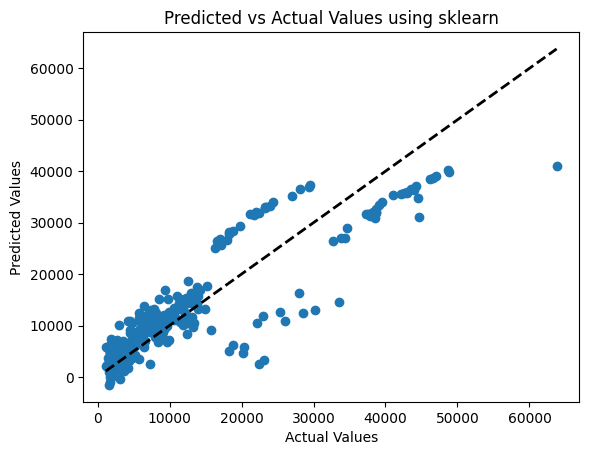

In [8]:
#usando sklearn
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)
#coefficients
coefficients_sklearn = pd.Series(model.coef_, index=X_train.columns)
print("Coefficients using sklearn:")
print(coefficients_sklearn)
y_pred_sklearn = model.predict(X_test)

print("R²:", r2_score(y_test, y_pred_sklearn))

mape_sklearn = mean_absolute_percentage_error(y_test, y_pred_sklearn)
print(f"Mean Absolute Percentage Error (MAPE) using sklearn: {mape_sklearn * 100:.2f}%")
#we can also plot the predictions vs the actual values
plt.scatter(y_test, y_pred_sklearn)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values using sklearn")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2) #to plot the line y=x
plt.show()


Linear regression with Gradient Descent
====

Below is a simple implementation of linear regression using gradient descent.  We define a class `LinearRegression` that includes methods to train the model (`fit`) and make predictions (`predict`).

In [9]:
import numpy as np

class LinearRegression:
    def __init__(self, learning_rate, n_iterations):
        # Initialize learning rate and number of iterations
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.weights = None  # To store feature weights
        self.bias = None     # To store the bias term

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)  # Initialize weights with zeros
        self.bias = 0                         # Initialize bias to zero

        for _ in range(self.n_iterations):
            # Compute predicted values
            y_predicted = np.dot(X, self.weights) + self.bias

            # Compute gradients with respect to weights and bias
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)

            # Update parameters using gradient descent
            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def predict(self, X):
        # Return the predicted values using the learned weights and bias
        return np.dot(X, self.weights) + self.bias


Now we make predictions with our linear regression with gradient descent. But fitst, we need to normalize the features because gradient descent converges faster and more reliably when the input variables are on a similar scale.

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Normalize X
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Normalize y
scaler_y = MinMaxScaler()
# We use .ravel() to convert the 2D array returned by MinMaxScaler (shape: [n_samples, 1])
# into a 1D array (shape: [n_samples,]) as expected by our custom LinearRegression model.
# This avoids shape mismatch issues during matrix operations like dot products
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

# We train our model
model = LinearRegression(learning_rate=0.01, n_iterations=1000)
model.fit(X_train_scaled, y_train_scaled)

#we print the coefficients
coefficients_gradient_descent= pd.Series(model.weights, index=X_train.columns)
print("Coefficients using custom LinearRegression:")
print(coefficients_gradient_descent)


# To perform predictions
y_pred_scaled = model.predict(X_test_scaled)

# Before measuring MAPE, we need to inverse transform the predictions and the true values
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
y_true = y_test.values  # original test values (already not normalized)

# Calcular MAPE
mape_gd = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape_gd:.2f}%")


Coefficients using custom LinearRegression:
age                 0.120412
bmi                 0.061249
children            0.024942
sex_male            0.003419
smoker_yes          0.304360
region_northwest   -0.000733
region_southeast    0.014210
region_southwest   -0.002184
dtype: float64
MAPE: 74.96%
